# Part 2: Compare performance of different Transformer Architectures

DistilGPT2 is selected for comparison with other transformer models

## Lib & Dependencies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn

from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

from transformers import AdamW
from transformers import AutoTokenizer, GPT2Model

import time
from tqdm import tqdm

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Import Data

In [3]:
df = pd.read_csv('data/IMDB Dataset.csv')
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


## Data Cleaning

In [4]:
df.drop_duplicates(inplace=True)

## Preprocessing

In [5]:
df['sentiment'] = df['sentiment'].map({'positive': 1, 'negative': 0})
X_train, X_test, y_train, y_test = train_test_split(df['review'], df['sentiment'], test_size=0.2, random_state=42)

## Model

In [6]:
# since we are not modifying the model after training, we will load the pretrained model directly instead of the config
class DistilGPT2ForSequenceClassification(nn.Module):
    def __init__(self, num_labels):
        super(DistilGPT2ForSequenceClassification, self).__init__()
        # Load the pre-trained DistilGPT2 model
        self.distil_gpt2 = GPT2Model.from_pretrained("distilbert/distilgpt2")
        self.classifier = nn.Linear(self.distil_gpt2.config.hidden_size, 1)

    def forward(self, input_ids, attention_mask=None):
        outputs = self.distil_gpt2(input_ids, attention_mask=attention_mask)
        logits = self.classifier(outputs['last_hidden_state'][:,-1,:])
        probabilities = torch.sigmoid(logits)
        return probabilities

In [7]:
class IMDbDataset(Dataset):
    def __init__(self, reviews, sentiments, tokenizer, max_len):
        self.reviews = reviews
        self.sentiments = sentiments
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, idx):
        review = self.reviews.iloc[idx]
        sentiment = self.sentiments.iloc[idx]
        encoding = self.tokenizer.encode_plus(
            review,
            truncation=True,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'review_text': review,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'sentiment': torch.tensor(sentiment, dtype=torch.long)
        }

tokenizer = AutoTokenizer.from_pretrained("distilbert/distilgpt2")
tokenizer.pad_token = tokenizer.eos_token

D:\Conda\envs\sc4001env\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [8]:
MAX_LEN = 256
BATCH_SIZE = 32

train_dataset = IMDbDataset(X_train, y_train, tokenizer, MAX_LEN)
test_dataset = IMDbDataset(X_test, y_test, tokenizer, MAX_LEN)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [9]:
model = DistilGPT2ForSequenceClassification(2)
model = model.to(device)

optimizer = AdamW(model.parameters(), lr=2e-5)

def loss_fn(outputs, targets):
    return nn.BCEWithLogitsLoss()(outputs, targets)

D:\Conda\envs\sc4001env\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [10]:
num_params = sum(p.numel() for p in model.parameters())

print(f'Total number of parameters: {num_params}')

Total number of parameters: 81913345


In [27]:
def train_epoch(model, data_loader, optimizer, device):
    model.train()
    train_loss = 0
    correct_predictions = 0

    for batch in tqdm(data_loader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        sentiments = batch['sentiment'].to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = loss_fn(outputs.squeeze(), sentiments.type(torch.float))
        
        train_loss += loss.item() 
        correct_predictions += ((outputs.squeeze() > 0.5).type(torch.float) == sentiments).type(torch.float).sum().item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    return correct_predictions / len(data_loader.dataset), train_loss / len(data_loader)

# Evaluation function
def evaluate_model(model, data_loader, device):
    model.eval()
    test_loss = 0
    correct_predictions = 0

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            sentiments = batch['sentiment'].to(device)
            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = loss_fn(outputs.squeeze(), sentiments.type(torch.float))
            
            test_loss += loss.item() 
            correct_predictions += ((outputs.squeeze() > 0.5).type(torch.float) == sentiments).type(torch.float).sum().item()

    return correct_predictions / len(data_loader.dataset), test_loss / len(data_loader)

In [28]:
EPOCHS = 3

times = []
train_losses = []
train_accs = []
test_losses = []
test_accs = []

for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    start_time = time.time()
    
    train_acc, train_loss = train_epoch(model, train_loader, optimizer, device)
    print(f'Train loss: {train_loss}, accuracy: {train_acc}')
    train_accs.append(train_acc)
    train_losses.append(train_loss)
    
    test_acc, test_loss = evaluate_model(model, test_loader, device)
    print(f'Test loss: {test_loss}, accuracy: {test_acc}')
    test_accs.append(test_acc)
    test_losses.append(test_loss)
    
    time_taken = time.time()-start_time
    print(f'time taken: {time_taken}')
    times.append(time_taken)

Epoch 1/3


100%|██████████████████████████████████████████████████████████████████████████████| 1240/1240 [29:33<00:00,  1.43s/it]


Train loss: 0.5951985639429862, accuracy: 0.7763771587041473
Test loss: 0.5575721582097392, accuracy: 0.8762730664515479
time taken: 1923.909643650055
Epoch 2/3


100%|██████████████████████████████████████████████████████████████████████████████| 1240/1240 [29:58<00:00,  1.45s/it]


Train loss: 0.5545153904345728, accuracy: 0.8857935207361654
Test loss: 0.5606242813410297, accuracy: 0.8883735000504185
time taken: 1949.415093421936
Epoch 3/3


100%|██████████████████████████████████████████████████████████████████████████████| 1240/1240 [30:10<00:00,  1.46s/it]


Train loss: 0.5486322161170745, accuracy: 0.899609227278457
Test loss: 0.5772318547771823, accuracy: 0.805989714631441
time taken: 1963.7937150001526


In [29]:
# Evaluate the model on test set
y_pred = []
y_true = []

model.eval()
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        sentiments = batch['sentiment'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        y_pred.extend((outputs.squeeze() > 0.5).type(torch.float).cpu().numpy())
        y_true.extend(sentiments.cpu().numpy())

# Print classification report
print(classification_report(y_true, y_pred, target_names=['negative', 'positive']))

              precision    recall  f1-score   support

    negative       0.73      0.98      0.83      4939
    positive       0.97      0.63      0.77      4978

    accuracy                           0.81      9917
   macro avg       0.85      0.81      0.80      9917
weighted avg       0.85      0.81      0.80      9917



In [33]:
model.save_pretrained("./saved_model/model_distilgpt2C2/")

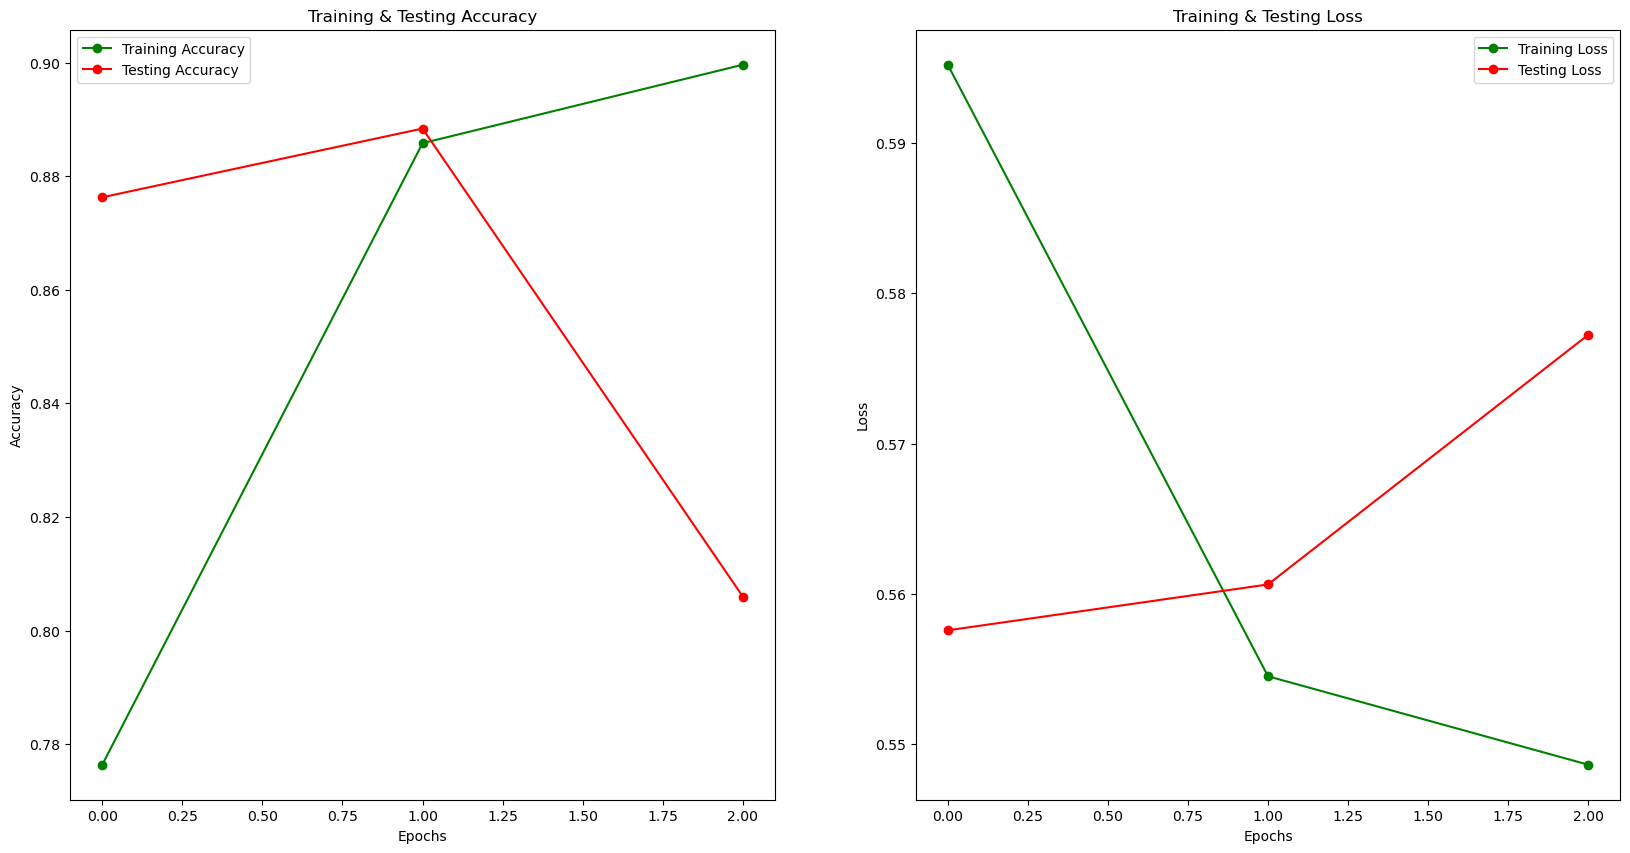

In [30]:
epochs = [i for i in range(3)]
fig , ax = plt.subplots(1,2)
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_accs, 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , test_accs, 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Testing Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_losses , 'go-' , label = 'Training Loss')
ax[1].plot(epochs , test_losses , 'ro-' , label = 'Testing Loss')
ax[1].set_title('Training & Testing Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

In [31]:
print(f'train_accs: {train_accs}')
print(f'test_accs: {test_accs}')
print(f'train_losses: {train_losses}')
print(f'test_losses: {test_losses}')

train_accs: [0.7763771587041473, 0.8857935207361654, 0.899609227278457]
test_accs: [0.8762730664515479, 0.8883735000504185, 0.805989714631441]
train_losses: [0.5951985639429862, 0.5545153904345728, 0.5486322161170745]
test_losses: [0.5575721582097392, 0.5606242813410297, 0.5772318547771823]


Text(95.72222222222221, 0.5, 'Actual')

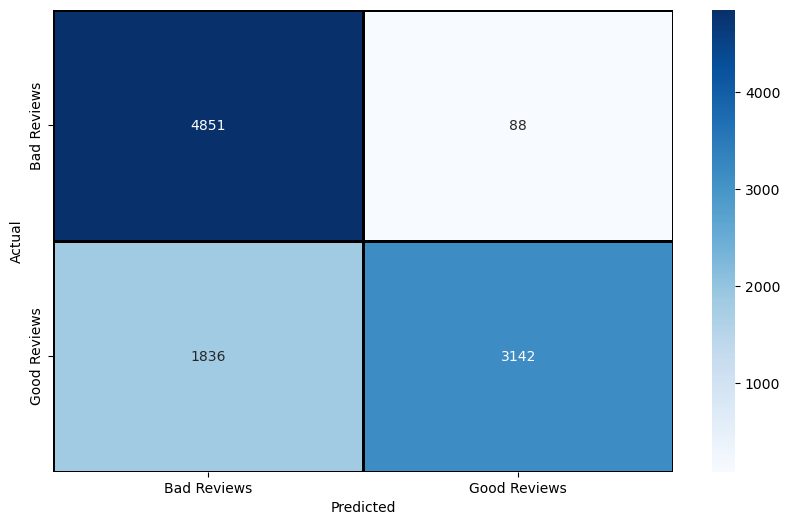

In [32]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true,y_pred)
plt.figure(figsize = (10,6))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Bad Reviews','Good Reviews'] , yticklabels = ['Bad Reviews','Good Reviews'])
plt.xlabel("Predicted")
plt.ylabel("Actual")

To deal with domain adaptation, that is, how can one adapt a network train on one domain to 
work in another domain